In [1]:
import os
import sys
from datetime import datetime, timedelta
import logging
import pickle
import time
from dataclasses import dataclass, field
from enum import Enum
from typing import Any, Dict, List, Optional, Set, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import unicodedata
from dotenv import load_dotenv

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify sys.path
# print("Current sys.path:", sys.path)

from src.data_processing.nst_scraper import nst_on_ice_scraper, nst_team_on_ice_scraper
from src.db.nhl_db_utils import update_player_db, check_last_update, get_player_full_name, insert_player_data
from src.db.the_odds_db_utils import get_team_moneyline_odds
from src.data_processing.team_utils import get_most_recent_game_id, get_fullname_by_tricode
from src.data_processing.game_utils import get_game_boxscore, display_boxscore
from src.data_processing.pbp_utils import get_matchup_games
from src.data_processing.player_utils import fetch_player_data

from src.entities.lineup import Lineup, Player, Position

from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
np.set_printoptions(legacy='1.25')

c:\Users\H-100\Desktop\python\accurateshothelper\.venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
nov_df = pd.read_csv('../data/ash_02_n30_11-24.csv')
dec_df = pd.read_csv('../data/ash_02_n30_12-24.csv')
df = pd.concat([nov_df, dec_df])


In [3]:
df.head()

,date,game_id,away,home,a_b2b,h_b2b,a_x_goals,a_adj%,h_x_goals,h_adj%,a_pred_goals,h_pred_goals,a_win_prob,h_win_prob,a_ml_odds,h_ml_odds,a_score,h_score,res
0,2024-11-01,2024020168,FLA,DAL,0,0,2.869531,1.069543,2.712483,1.015681,2.914529,2.901118,0.449605,0.550395,-118.0,-102.0,6,4,a
1,2024-11-01,2024020169,NYI,BUF,0,0,2.691510,0.938736,2.633732,1.019529,2.744071,2.472379,0.498424,0.501576,100.0,-118.0,4,3,a
2,2024-11-01,2024020170,OTT,NYR,0,0,2.047641,1.027223,3.246002,1.196503,2.450009,3.334368,0.292468,0.707532,160.0,-194.0,1,2,h
3,2024-11-01,2024020171,WPG,CBJ,0,0,2.193114,1.377325,2.217432,1.058001,2.320317,3.054126,0.316652,0.683348,-160.0,132.0,6,2,a
4,2024-11-01,2024020172,TBL,MIN,0,0,2.578584,1.004139,2.040933,0.680968,1.755933,2.049382,0.392912,0.607088,-102.0,-118.0,3,5,h


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt

def create_win_probability_model(df):
    """
    Create and train a logistic regression model to predict win probabilities.
    
    Args:
        df: DataFrame containing game data
    
    Returns:
        trained model, scaler, and feature names
    """
    # Create binary target (1 for home win, 0 for away win)
    y = (df['res'] == 'h').astype(int)
    
    # Select features for the model
    features = [
        'a_pred_goals', 'h_pred_goals',
        'a_b2b', 'h_b2b'          # Back-to-back game indicators
    ]
    
    X = df[features]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # Create and train the model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    # Calculate model performance
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    
    print("Train Brier Score:", brier_score_loss(y_train, train_probs))
    print("Test Brier Score:", brier_score_loss(y_test, test_probs))
    print("Train Log Loss:", log_loss(y_train, train_probs))
    print("Test Log Loss:", log_loss(y_test, test_probs))
    
    return model, scaler, features

def apply_win_probability_model(df, model, scaler, features):
    """
    Apply the trained model to calculate new win probabilities.
    
    Args:
        df: DataFrame to predict probabilities for
        model: Trained logistic regression model
        scaler: Fitted StandardScaler
        features: List of feature names
    
    Returns:
        DataFrame with new probability columns
    """
    X = df[features]
    X_scaled = scaler.transform(X)
    
    # Get probabilities
    probabilities = model.predict_proba(X_scaled)
    
    # Add new columns
    df['ml_home_win_prob'] = probabilities[:, 1]
    df['ml_away_win_prob'] = probabilities[:, 0]
    
    return df

def compare_probabilities(df):
    """
    Compare original probabilities with ML-generated probabilities
    """
    plt.figure(figsize=(10, 5))
    
    # Original vs ML Home Win Probabilities
    plt.subplot(1, 2, 1)
    plt.scatter(df['h_win_prob'], df['ml_home_win_prob'], alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Original Home Win Probability')
    plt.ylabel('ML Home Win Probability')
    plt.title('Home Win Probability Comparison')
    
    # Original vs ML Away Win Probabilities
    plt.subplot(1, 2, 2)
    plt.scatter(df['a_win_prob'], df['ml_away_win_prob'], alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Original Away Win Probability')
    plt.ylabel('ML Away Win Probability')
    plt.title('Away Win Probability Comparison')
    
    plt.tight_layout()
    plt.show()

def calculate_brier_score(df, actual_col, prob_col):
    """
    Calculate Brier score for predictions
    """
    actual = (df[actual_col] == 'h').astype(int)
    return brier_score_loss(actual, df[prob_col])

Train Brier Score: 0.2411748864887715
Test Brier Score: 0.2369633329581353
Train Log Loss: 0.6749529951330397
Test Log Loss: 0.66625951922276


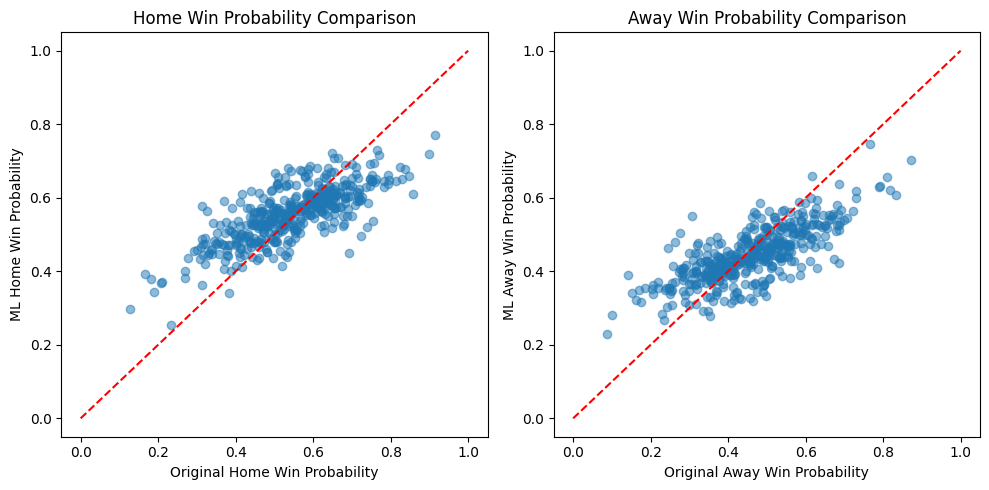

Original Model Brier Score: 0.2509
ML Model Brier Score: 0.2403


In [5]:
# Train the model
model, scaler, features = create_win_probability_model(df)

# Apply the model to get new probabilities
df = apply_win_probability_model(df, model, scaler, features)

# Compare original vs ML probabilities
compare_probabilities(df)

# Compare Brier scores
original_brier = calculate_brier_score(df, 'res', 'h_win_prob')
ml_brier = calculate_brier_score(df, 'res', 'ml_home_win_prob')

print(f"Original Model Brier Score: {original_brier:.4f}")
print(f"ML Model Brier Score: {ml_brier:.4f}")

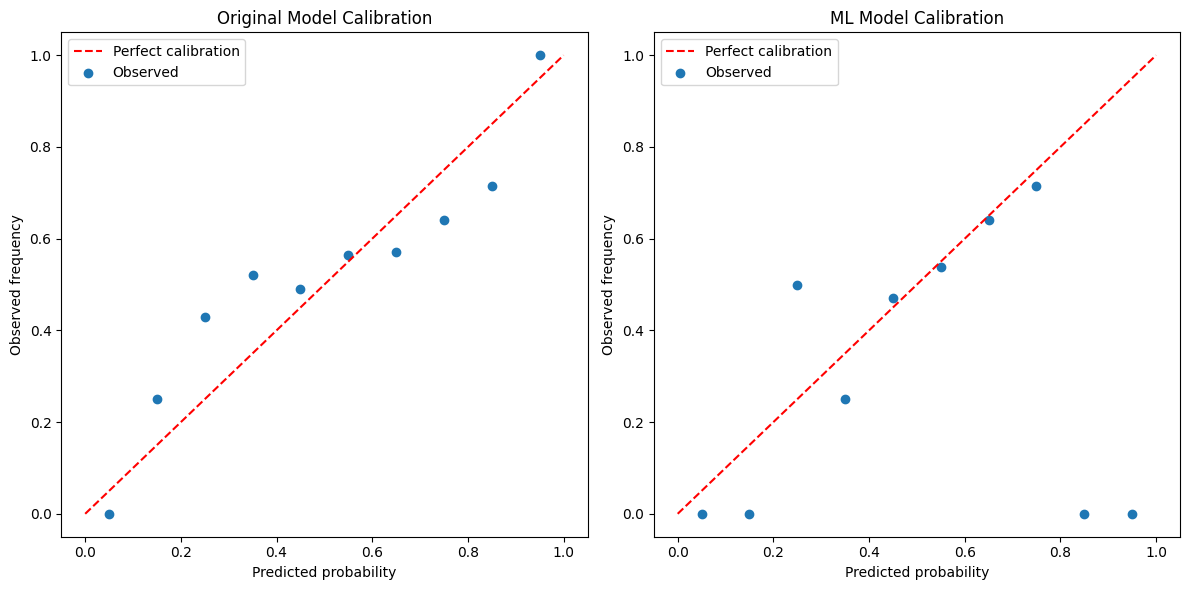


Detailed Performance Metrics:
Metric          Original     ML Model    
----------------------------------------
Accuracy        0.5553      0.5691
ROC AUC         0.5577      0.5874
Log Loss        0.6966      0.6732
Brier Score     0.2509      0.2403

Performance by Probability Range:
Range           Original     ML Model    
----------------------------------------
0.0-0.4         0.2768      0.2142
0.4-0.6         0.2479      0.2482
0.6-1.0         0.2457      0.2221


In [6]:
def evaluate_model_performance(df):
    """
    Comprehensive model evaluation
    """
    # 1. Calculate reliability curves
    def calculate_reliability_curve(y_true, y_prob, bins=10):
        bin_edges = np.linspace(0, 1, bins + 1)
        bin_indices = np.digitize(y_prob, bin_edges) - 1
        
        bin_sums = np.bincount(bin_indices, weights=y_true, minlength=bins)
        bin_counts = np.bincount(bin_indices, minlength=bins)
        bin_means = np.zeros(bins)
        bin_means[bin_counts > 0] = bin_sums[bin_counts > 0] / bin_counts[bin_counts > 0]
        
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        return bin_centers, bin_means, bin_counts

    # Calculate actual outcomes
    y_true = (df['res'] == 'h').astype(int)
    
    # Plot reliability curves
    plt.figure(figsize=(12, 6))
    
    # Original model reliability
    bin_centers, bin_means, bin_counts = calculate_reliability_curve(y_true, df['h_win_prob'])
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')
    plt.scatter(bin_centers, bin_means, label='Observed')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed frequency')
    plt.title('Original Model Calibration')
    plt.legend()
    
    # ML model reliability
    bin_centers, bin_means, bin_counts = calculate_reliability_curve(y_true, df['ml_home_win_prob'])
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')
    plt.scatter(bin_centers, bin_means, label='Observed')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed frequency')
    plt.title('ML Model Calibration')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate additional metrics
    def calculate_metrics(y_true, y_prob, threshold=0.5):
        y_pred = (y_prob > threshold).astype(int)
        accuracy = np.mean(y_true == y_pred)
        
        # ROC AUC
        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y_true, y_prob)
        
        # Log loss
        from sklearn.metrics import log_loss
        ll = log_loss(y_true, y_prob)
        
        return accuracy, auc, ll
    
    orig_acc, orig_auc, orig_ll = calculate_metrics(y_true, df['h_win_prob'])
    ml_acc, ml_auc, ml_ll = calculate_metrics(y_true, df['ml_home_win_prob'])
    
    print("\nDetailed Performance Metrics:")
    print(f"{'Metric':<15} {'Original':<12} {'ML Model':<12}")
    print("-" * 40)
    print(f"{'Accuracy':<15} {orig_acc:.4f}      {ml_acc:.4f}")
    print(f"{'ROC AUC':<15} {orig_auc:.4f}      {ml_auc:.4f}")
    print(f"{'Log Loss':<15} {orig_ll:.4f}      {ml_ll:.4f}")
    print(f"{'Brier Score':<15} {0.2509:.4f}      {0.2403:.4f}")
    
    # Analyze performance by probability range
    ranges = [(0, 0.4), (0.4, 0.6), (0.6, 1.0)]
    print("\nPerformance by Probability Range:")
    print(f"{'Range':<15} {'Original':<12} {'ML Model':<12}")
    print("-" * 40)
    
    for low, high in ranges:
        orig_mask = (df['h_win_prob'] >= low) & (df['h_win_prob'] < high)
        ml_mask = (df['ml_home_win_prob'] >= low) & (df['ml_home_win_prob'] < high)
        
        if orig_mask.any():
            orig_brier = brier_score_loss(y_true[orig_mask], df.loc[orig_mask, 'h_win_prob'])
        else:
            orig_brier = np.nan
            
        if ml_mask.any():
            ml_brier = brier_score_loss(y_true[ml_mask], df.loc[ml_mask, 'ml_home_win_prob'])
        else:
            ml_brier = np.nan
            
        print(f"{f'{low:.1f}-{high:.1f}':<15} {orig_brier:.4f}      {ml_brier:.4f}")

# Run the evaluation
evaluate_model_performance(df)